# Malware Analysis Using Machine Learning  

This project focuses on **Advanced Persistent Threat (APT) malware analysis**, OpCode extraction, and machine learning-based classification. In this section,  Reproducing the methodology from "Deep Android Malware Detection" (reference paper) and benchmarking against traditional approaches.  

## Key Details  
- **Dataset:** `Malware_Opcodes/apt_malware_opcode_dataset.csv`  
- **Methods Used:** CNN  


## Step 1: Setting Up the Environment (with GPU Acceleration)

To efficiently train the deep learning model, the environment has been configured to utilize GPU acceleration. GPUs are capable of performing parallel computations, which significantly speeds up training times for deep neural networks.

### Required Libraries

The following libraries are required:
- **PyTorch:** For building and training the neural network.
- **Pandas:** For data manipulation and analysis.
- **Scikit-learn:** For splitting the dataset and evaluating model performance.
- **Matplotlib & Seaborn:** For data visualization.
- **NumPy:** For numerical operations.

These packages can be installed with the following command:


In [9]:
pip install torch torchvision torchaudio pandas scikit-learn matplotlib seaborn numpy

Note: you may need to restart the kernel to use updated packages.


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Step 2: Initial data Preparation and filtering

In this section, the raw metadata is loaded and the opcode sequences are extracted from each file. A CSV file (`apt_opcode_dataset.csv`) is created by reading file paths from the metadata and extracting the opcode column. Files that are missing or contain insufficient data are handled appropriately.

After creating the initial dataset, samples with fewer than 10 opcodes are filtered out to ensure only meaningful data is retained. The filtered dataset is saved as `filtered_apt_opcode_dataset.csv` and the distribution of APT labels is examined to provide an overview of the data before further processing.


In [38]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("metadata.csv")
base_dir = "C:/Users/nisal/cnn_venv/cnn/"

def read_opcodes(file_path):
    full_path = os.path.join(base_dir, file_path)
    try:
        with open(full_path, "r") as f:
            lines = f.readlines()
            if len(lines) < 2:
                return ""  
            return " ".join(line.strip().split(",")[1] for line in lines[1:] if "," in line)  # Extract opcode column
    except FileNotFoundError:
        print(f"Warning: File not found - {full_path}")
        return ""  # Return empty string if file is missing

df["OpCodes"] = df["Opcode File Path"].apply(read_opcodes)
df = df[["OpCodes", "APT"]]
df.to_csv("apt_opcode_dataset.csv", index=False)

print("APT Opcode dataset saved as 'apt_opcode_dataset.csv'")

APT Opcode dataset saved as 'apt_opcode_dataset.csv'


In [39]:
# Load raw opcode dataset
df = pd.read_csv("apt_opcode_dataset.csv")
print(f"Initial samples: {len(df)}")

# Filter samples with <10 opcodes
df["Opcode_Count"] = df["OpCodes"].apply(lambda x: len(x.split()))
df_filtered = df[df["Opcode_Count"] >= 10].copy()
print(f"Removed {len(df) - len(df_filtered)} samples with low opcode counts")

# Save filtered data
df_filtered.to_csv("filtered_apt_opcode_dataset.csv", index=False)
print("\nClass distribution after filtering:")
print(df_filtered["APT"].value_counts())

Initial samples: 93
Removed 7 samples with low opcode counts

Class distribution after filtering:
APT
Naikon             18
Mustang Panda      15
Rocke              10
Ke3chang            9
Mofang              8
Putter Panda        7
menuPass            5
Operation Wocao     5
Suckfly             5
PittyTiger          4
Name: count, dtype: int64


### Step3: Dataset Creation

In [40]:
class OpcodeDataset(Dataset):
    def __init__(self, sequences, labels, max_len=15000):
        self.tokenizer = LabelEncoder()
        all_opcodes = [opcode for seq in sequences for opcode in seq.split()]
        self.tokenizer.fit(all_opcodes)
        
        self.sequences = sequences
        self.labels = LabelEncoder().fit_transform(labels)
        self.num_classes = len(np.unique(self.labels))
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx].split()
        encoded = self.tokenizer.transform(seq)
        padded = np.zeros(self.max_len, dtype=np.int64)
        length = min(len(encoded), self.max_len)
        padded[:length] = encoded[:length]
        return torch.tensor(padded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

In [41]:
dataset = OpcodeDataset(df_filtered["OpCodes"].values, df_filtered["APT"].values)

# Stratified split using indices
train_idx, val_idx = train_test_split(
    range(len(dataset)), 
    test_size=0.2, 
    stratify=dataset.labels,
    random_state=42
)

# Create subsets
train_dataset = Subset(dataset, train_idx)  # Now works with imported Subset
val_dataset = Subset(dataset, val_idx)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")


Train samples: 68
Validation samples: 18


## Step 4: CNN Model Creation

A deep convolutional neural network (CNN) has been defined to classify malware based on raw opcode sequences by reffering the model described in paper 'Deep Android Malware Detection'.

In [42]:
class MalwareCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=8, num_classes=11):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=8)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)  # [batch, embed_dim, seq_len]
        x = torch.relu(self.conv1(x))
        x = self.pool(x).squeeze(-1)
        x = torch.relu(self.fc1(self.dropout(x)))
        return self.fc2(x)

model = MalwareCNN(vocab_size=len(dataset.tokenizer.classes_)).to(device)
print(model)

MalwareCNN(
  (embedding): Embedding(398, 8)
  (conv1): Conv1d(8, 64, kernel_size=(8,), stride=(1,))
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=64, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=11, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## Step 5: Training the Model

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 10  # Number of epochs to wait before stopping
best_val_accuracy = 0
no_improvement = 0

# Track metrics
history = {'train_loss': [], 'val_accuracy': []}

for epoch in range(100):  # Now set to maximum epochs
    # Training phase
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    history['train_loss'].append(train_loss / len(train_loader))
    
    # Validation phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    val_accuracy = correct / total
    history['val_accuracy'].append(val_accuracy)
    
    print(f"Epoch {epoch+1}: Train Loss = {history['train_loss'][-1]:.4f}, Val Acc = {val_accuracy:.4f}")
    
    # Early stopping logic
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        no_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved (Acc: {best_val_accuracy:.4f})")
    else:
        no_improvement += 1
        if no_improvement >= patience:
            print(f"\nEarly stopping at epoch {epoch+1} (No improvement for {patience} epochs)")
            break

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
print(f"\nTraining complete. Best validation accuracy: {best_val_accuracy:.4f}")

Epoch 1: Train Loss = 2.1033, Val Acc = 0.4444
New best model saved (Acc: 0.4444)
Epoch 2: Train Loss = 2.0073, Val Acc = 0.5556
New best model saved (Acc: 0.5556)
Epoch 3: Train Loss = 1.9604, Val Acc = 0.5556
Epoch 4: Train Loss = 1.9442, Val Acc = 0.5556
Epoch 5: Train Loss = 1.7895, Val Acc = 0.6111
New best model saved (Acc: 0.6111)
Epoch 6: Train Loss = 1.7339, Val Acc = 0.4444
Epoch 7: Train Loss = 1.7434, Val Acc = 0.5556
Epoch 8: Train Loss = 1.7358, Val Acc = 0.5556
Epoch 9: Train Loss = 1.7973, Val Acc = 0.5000
Epoch 10: Train Loss = 1.7387, Val Acc = 0.7222
New best model saved (Acc: 0.7222)
Epoch 11: Train Loss = 1.6641, Val Acc = 0.6667
Epoch 12: Train Loss = 1.6675, Val Acc = 0.6667
Epoch 13: Train Loss = 1.6184, Val Acc = 0.7222
Epoch 14: Train Loss = 1.7190, Val Acc = 0.6667
Epoch 15: Train Loss = 1.5248, Val Acc = 0.7778
New best model saved (Acc: 0.7778)
Epoch 16: Train Loss = 1.5920, Val Acc = 0.7778
Epoch 17: Train Loss = 1.5212, Val Acc = 0.7222
Epoch 18: Train Lo

## Step 6: Evaluating the Performance

Classification Report:
                 precision    recall  f1-score   support

   Putter Panda       0.67      1.00      0.80         2
         Naikon       1.00      1.00      1.00         2
       menuPass       1.00      1.00      1.00         3
          Rocke       0.67      1.00      0.80         4
     PittyTiger       0.00      0.00      0.00         1
Operation Wocao       0.00      0.00      0.00         1
       Ke3chang       1.00      1.00      1.00         1
        Suckfly       1.00      1.00      1.00         2
  Mustang Panda       1.00      1.00      1.00         1
         Mofang       0.00      0.00      0.00         1

       accuracy                           0.83        18
      macro avg       0.63      0.70      0.66        18
   weighted avg       0.72      0.83      0.77        18



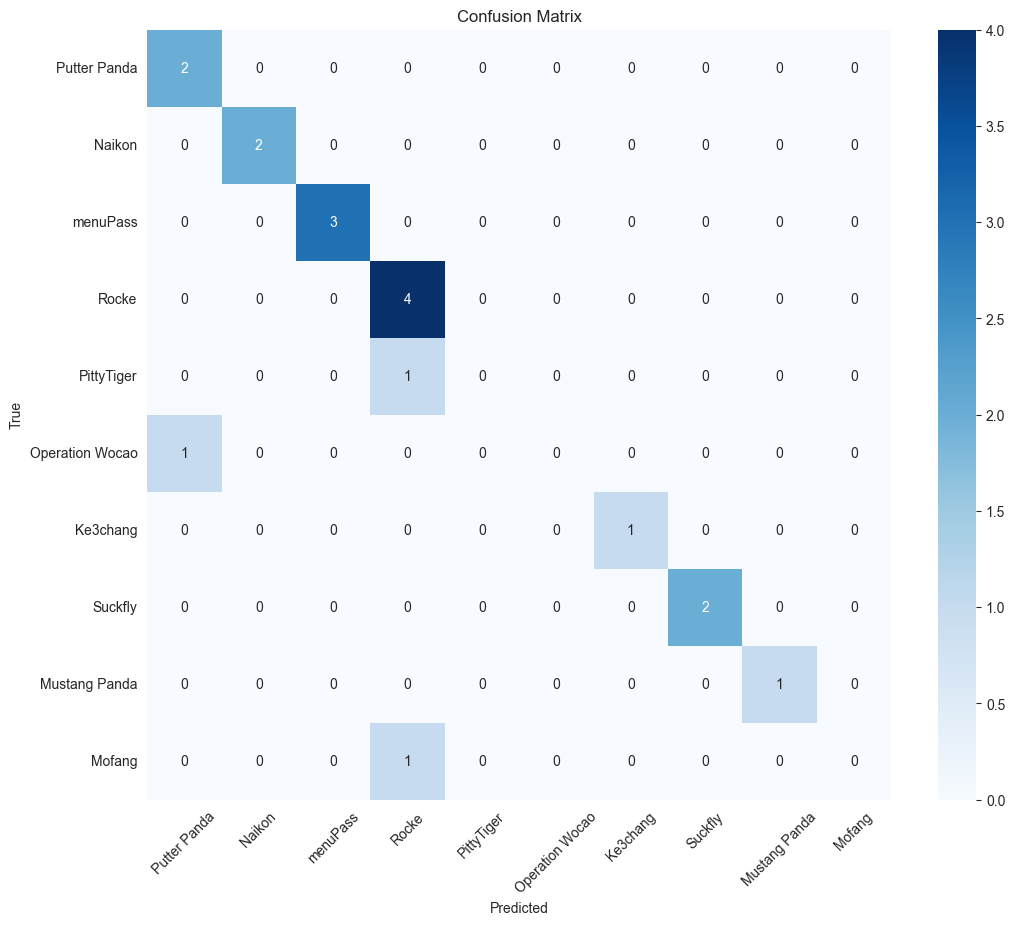

Accuracy: 0.8333


In [46]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.show()

def evaluate_model(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

# Run evaluation
class_names = df_filtered["APT"].unique()
val_accuracy = evaluate_model(model, val_loader, class_names)

## Step 7: Comparison with Previous models

<Figure size 2000x1200 with 0 Axes>

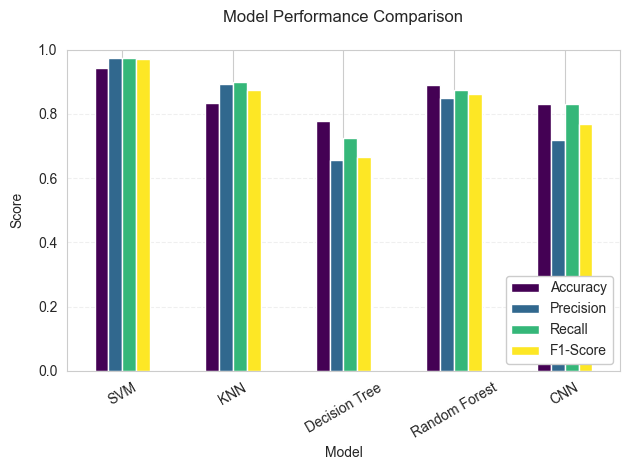

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create the DataFrame with your exact metrics
performance_df = pd.DataFrame({
    "Model": ["SVM", "KNN", "Decision Tree", "Random Forest", "CNN"],
    "Accuracy": [0.944, 0.833, 0.778, 0.889, 0.83],
    "Precision": [0.975, 0.892, 0.658, 0.850, 0.72],
    "Recall": [0.975, 0.900, 0.725, 0.875, 0.83],
    "F1-Score": [0.971, 0.876, 0.665, 0.861, 0.77]
})

# 2. Generate the plot (your preferred style)
plt.figure(figsize=(20, 12))
performance_df.plot(
    x="Model",
    kind="bar",
    colormap="viridis",
    rot=30
)

# 3. Formatting (minimal cleanups)
plt.title("Model Performance Comparison", pad=20)
plt.ylabel("Score", labelpad=10)
plt.ylim(0, 1)  # Slightly above 1 for value labels
plt.legend(loc="lower right", framealpha=1)
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()